In [1]:
import numpy as np
import modin.pandas as mipd
import math
import os
import time
import json
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx.algorithms import bipartite
from collections import Counter
from scipy.stats import entropy

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
time_resolution = 1
c_path = '../network_data'+str(time_resolution)+'/commits/'
e_path = '../network_data'+str(time_resolution)+'/emails/'

all_graduated_name = np.load('../all_graduated.npy').tolist()
all_graduated = [x.lower() for x in all_graduated_name]
all_retired_name = np.load('../all_retired.npy').tolist()
all_retired = [x.lower() for x in all_retired_name]

In [3]:
def get_net_dict(net1):

    if not os.path.exists(net1):
        return None

    net1_dict = {}
    with open(net1, 'r') as f:
        lines = f.read().splitlines()
	# print([net1, net2])
    for line in lines:
        sender, receiver, weight = line.split('##')
        #print(sender)
        #print(receiver)
        if not (sender in net1_dict.keys()):
            net1_dict[sender] = {}
        net1_dict[sender][receiver] = int(weight)
    
    return net1_dict

def get_net_dict_reverse(net1):

    if not os.path.exists(net1):
        return None

    net1_dict = {}
    with open(net1, 'r') as f:
        lines = f.read().splitlines()
	# print([net1, net2])
    for line in lines:
        sender, receiver, weight = line.split('##')
        if not (receiver in net1_dict.keys()):
            net1_dict[receiver] = {}
        if not (sender in net1_dict[receiver].keys()):
            net1_dict[receiver][sender] = int(weight)
        else:
            net1_dict[receiver][sender]+= int(weight)
    
    return net1_dict

def get_net_dict_and_reverse(net1):

    if not os.path.exists(net1):
        return None

    net1_dict = {}
    with open(net1, 'r') as f:
        lines = f.read().splitlines()
	# print([net1, net2])
    for line in lines:
        sender, receiver, weight = line.split('##')
        if not (sender in net1_dict.keys()):
            net1_dict[sender] = {}
        net1_dict[sender][receiver] = int(weight)
        if not (receiver in net1_dict.keys()):
            net1_dict[receiver] = {}
        if not (sender in net1_dict[receiver].keys()):
            net1_dict[receiver][sender] = int(weight)
        else:
            net1_dict[receiver][sender]+= int(weight)
    
    return net1_dict

In [4]:
def get_all_net_dict(the_path, projid):

    all_net_dict = {}
    
    for seq_num in range(0, 36):

        this_fname = the_path+projid+'__'+str(seq_num)+".edgelist"
        this_dict = get_net_dict(this_fname)
        #while os.path.exists(this_fname):
        if this_dict:
            #print(this_dict)
            for key in this_dict.keys():
                #print(key)
                if key in set(all_net_dict.keys()):
                    all_net_dict[key] = dict(Counter(this_dict[key])+Counter(all_net_dict[key]))
                    #print(all_net_dict)
                else:
                    all_net_dict[key] = this_dict[key]
                    #print(all_net_dict)
        else:
            continue
    return all_net_dict

def get_all_net_dict_reverse(the_path, projid):

    all_net_dict = {}
    
    for seq_num in range(0, 36):

        this_fname = the_path+projid+'__'+str(seq_num)+".edgelist"
        this_dict = get_net_dict_reverse(this_fname)
        #while os.path.exists(this_fname):
        if this_dict:
            #print(this_dict)
            for key in this_dict.keys():
                #print(key)
                if key in set(all_net_dict.keys()):
                    all_net_dict[key] = dict(Counter(this_dict[key])+Counter(all_net_dict[key]))
                    #print(all_net_dict)
                else:
                    all_net_dict[key] = this_dict[key]
                    #print(all_net_dict)
        else:
            continue
    return all_net_dict

def get_all_net_dict_andreverse(the_path, projid):

    all_net_dict = {}
    
    for seq_num in range(0, 36):

        this_fname = the_path+projid+'__'+str(seq_num)+".edgelist"
        this_dict = get_net_dict_and_reverse(this_fname)
        #while os.path.exists(this_fname):
        if this_dict:
            #print(this_dict)
            for key in this_dict.keys():
                #print(key)
                if key in set(all_net_dict.keys()):
                    all_net_dict[key] = dict(Counter(this_dict[key])+Counter(all_net_dict[key]))
                    #print(all_net_dict)
                else:
                    all_net_dict[key] = this_dict[key]
                    #print(all_net_dict)
        else:
            continue
    return all_net_dict
    

In [5]:
def node_entropy_calc(node_dict):
    if len(node_dict)<=1:
        return 0.0
    counts = np.array(list(node_dict.values()))
    sum_all = float(sum(node_dict.values()))
    probs = counts/sum_all
    entro = entropy(probs.tolist())
    
    return entro

def dict_entropy_calc(net_dict):
    if len(net_dict)<=1:
        return 0.0
    entro = 0.0
    counts = []
    sum_all = 0.0
    for sender in net_dict.keys():
        sum_this = sum(net_dict[sender].values())
        sum_all+= sum_this
        counts.append(sum_this) 
        #for receiver in net_dict[sender].keys():
    
    probs = np.array(counts)/sum_all
    entro = entropy(probs.tolist())
    
    emax = math.log(len(counts))
    #emin = math.log(4*(len(counts)-1))/2
    emin = 0

    return (entro-emin)/(emax-emin)

def dict_entropy_unweighted_calc(net_dict):
    if len(net_dict)<=1:
        return 0.0
    entro = 0.0
    counts = []
    sum_all = 0.0
    for sender in net_dict.keys():
        sum_this = len(net_dict[sender].values())
        sum_all+= sum_this
        counts.append(sum_this) 
        #for receiver in net_dict[sender].keys():
    
    probs = np.array(counts)/sum_all
    entro = entropy(probs.tolist())

    emax = math.log(len(counts))
    #emin = math.log(4*(len(counts)-1))/2
    emin = 0

    return (entro-emin)/(emax-emin)

### Calculate Individual Diversity (Weighted)
#### Modules

In [6]:
the_path = c_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_module_entropy = pd.DataFrame()
the_path = c_path
all_module_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict(the_path, projid)
    #print(proj_dict)
    #proj_entropy = dict_entropy_calc(proj_dict)
    proj_nodes_entropy = {}
    #proj_series_entropy.append(proj_entropy)
    for node in proj_dict.keys():
        this_node_entropy = node_entropy_calc(proj_dict[node])
        proj_nodes_entropy[node] = this_node_entropy
    
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_module_entropy[projname] = proj_nodes_entropy
    #print(projname)
    this_proj_nodes_e = list(proj_nodes_entropy.values())
    for seq_num in range(len(this_proj_nodes_e), 600):
        this_proj_nodes_e.append(-1.0)
    df_module_entropy[projname] = pd.Series(this_proj_nodes_e)
df_module_entropy = df_module_entropy.fillna(-1.0) 
df_module_entropy.to_csv("./module_entropy"+str(time_resolution)+".csv", index=None, sep=',')
    

100%|██████████| 263/263 [01:39<00:00,  2.65it/s]


In [7]:
df_module_entropy

,Edgent,hdt,Mnemonic,Juneau,odf,zeta,Streams,Oozie,Roller,Nuvem,...,pubscribe,Spark,Concerted,Nutch,Brooklyn,Kabuki,trafficserver,Beam,Airflow,Directory
0,0.000000,0.974315,0.000000,0.579915,0.636514,0.673012,1.090060,0.693147,0.636514,0.000000,...,0.562335,1.088004,0.673012,0.0,0.0,-1.0,0.000000,-1.0,0.000000,0.0
1,0.000000,0.636514,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.535960,0.636514,...,0.562335,0.693147,0.000000,0.0,0.0,-1.0,0.000000,-1.0,0.000000,0.0
2,1.277034,0.693147,0.334221,0.000000,0.000000,0.000000,0.636514,0.000000,1.299870,0.562335,...,0.410116,0.598270,0.000000,0.0,0.0,-1.0,0.000000,-1.0,0.000000,0.0
3,0.500402,0.000000,0.286836,0.000000,0.000000,0.000000,1.376055,0.000000,0.636514,0.673012,...,0.325083,0.000000,0.000000,0.0,0.0,-1.0,0.693147,-1.0,1.078992,0.0
4,0.000000,0.000000,0.000000,0.682908,0.000000,0.000000,0.682908,0.000000,0.636514,0.693147,...,0.304636,1.092831,0.000000,0.0,0.0,-1.0,0.000000,-1.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.636514,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0
596,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.519580,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0
597,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.621086,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0
598,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.579915,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0


In [8]:
all_g = list()
for x in all_graduated_name:
    if x in all_module_entropy.keys():
        all_g.append(x)
    elif x.lower() in all_module_entropy.keys():
        all_g.append(x.lower())

all_r = list()
for x in all_retired_name:
    if x in all_module_entropy.keys():
        all_r.append(x)
    elif x.lower() in all_module_entropy.keys():
        all_r.append(x.lower())

In [9]:
g_data = []
for proj in all_g:
    g_data.extend(df_module_entropy[proj].values.tolist())

r_data = []
for proj in all_r:
    r_data.extend(df_module_entropy[proj].values.tolist())

df_graph = pd.DataFrame()
df_graph["Retired"] = pd.Series(r_data)
df_graph["Graduated"] = pd.Series(g_data)


In [10]:
df_graph

,Retired,Graduated
0,0.000000,1.506818
1,0.000000,1.658417
2,0.621086,1.559577
3,0.000000,1.442673
4,0.429323,1.497785
...,...,...
32995,-1.000000,-1.000000
32996,-1.000000,-1.000000
32997,-1.000000,-1.000000
32998,-1.000000,-1.000000


In [11]:
dd = pd.melt(df_graph).dropna()

In [12]:
dd

,variable,value
0,Retired,0.000000
1,Retired,0.000000
2,Retired,0.621086
3,Retired,0.000000
4,Retired,0.429323
...,...,...
65995,Graduated,-1.000000
65996,Graduated,-1.000000
65997,Graduated,-1.000000
65998,Graduated,-1.000000


In [13]:
dd = dd.drop(dd[dd['value']==-1.0].index)

Text(0.5, 1.0, 'Compare Module Entropy : tech Networks')

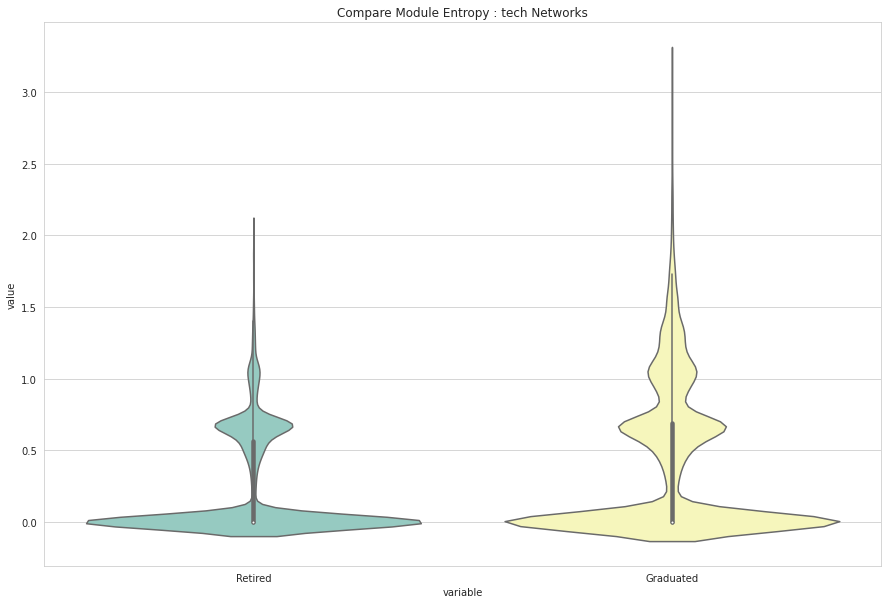

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="variable", y="value",
                    data=dd,
                    scale="width", palette="Set3")
plt.title("Compare Module Entropy : tech Networks")

Text(0.5, 1.0, 'Compare Module Entropy : tech Networks')

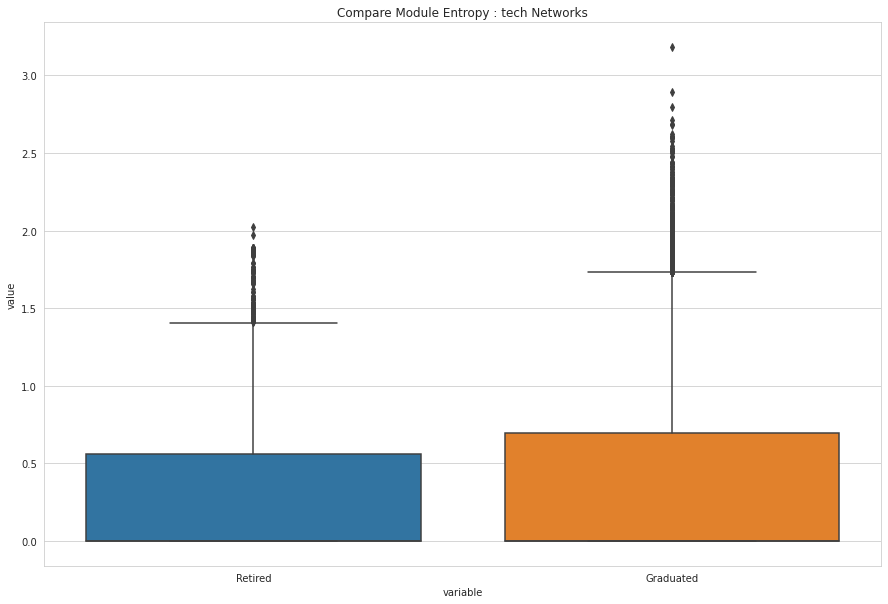

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.boxplot(x="variable", y="value",
                    data=dd)
plt.title("Compare Module Entropy : tech Networks")

#### Developers

In [16]:
the_path = c_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_developer_entropy = pd.DataFrame()
all_developer_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict_reverse(the_path, projid)
    #print(proj_dict)
    #proj_entropy = dict_entropy_calc(proj_dict)
    proj_nodes_entropy = {}
    #proj_series_entropy.append(proj_entropy)
    for node in proj_dict.keys():
        this_node_entropy = node_entropy_calc(proj_dict[node])
        proj_nodes_entropy[node] = this_node_entropy
    
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_developer_entropy[projname] = proj_nodes_entropy
    #print(projname)
    this_proj_nodes_e = list(proj_nodes_entropy.values())
    for seq_num in range(len(this_proj_nodes_e), 600):
        this_proj_nodes_e.append(-1.0)
    df_developer_entropy[projname] = pd.Series(this_proj_nodes_e)
df_developer_entropy = df_developer_entropy.fillna(-1.0) 
df_developer_entropy.to_csv("./developer_entropy"+str(time_resolution)+".csv", index=None, sep=',')
    

100%|██████████| 263/263 [00:02<00:00, 116.91it/s]


In [17]:
df_developer_entropy

,Edgent,hdt,Mnemonic,Juneau,odf,zeta,Streams,Oozie,Roller,Nuvem,...,pubscribe,Spark,Concerted,Nutch,Brooklyn,Kabuki,trafficserver,Beam,Airflow,Directory
0,3.224052,3.956826,4.631061,4.981037,4.316795,3.019751,1.956802,4.768412,3.054870,3.295104,...,4.325951,0.000000,0.000000,1.855130,4.266204,-1.0,4.606457,-1.0,0.000000,2.829238
1,4.588001,0.000000,0.693147,1.609438,4.915543,6.915892,3.340450,4.663655,6.120490,0.000000,...,4.245776,0.000000,3.271222,2.886165,1.581094,-1.0,4.201052,-1.0,0.636514,-1.000000
2,3.281687,3.680113,1.976266,1.609438,5.696779,2.772589,0.000000,5.216053,1.589027,4.640846,...,4.706810,3.904317,-1.000000,1.747868,2.908383,-1.0,1.747868,-1.0,1.732868,-1.000000
3,4.461308,-1.000000,3.867831,0.000000,0.000000,2.846324,3.997219,3.123304,3.171043,3.333177,...,-1.000000,4.360687,-1.000000,1.332179,2.971377,-1.0,2.441015,-1.0,0.000000,-1.000000
4,3.677416,-1.000000,1.386294,5.544483,1.386294,3.453460,0.000000,0.000000,5.373271,3.274444,...,-1.000000,4.663872,-1.000000,-1.000000,4.289711,-1.0,1.549826,-1.0,0.693147,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000
596,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000
597,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000
598,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000


In [18]:
all_g = list()
for x in all_graduated_name:
    if x in all_developer_entropy.keys():
        all_g.append(x)
    elif x.lower() in all_developer_entropy.keys():
        all_g.append(x.lower())

all_r = list()
for x in all_retired_name:
    if x in all_developer_entropy.keys():
        all_r.append(x)
    elif x.lower() in all_developer_entropy.keys():
        all_r.append(x.lower())

g_data = []
for proj in all_g:
    g_data.extend(df_developer_entropy[proj].values.tolist())

r_data = []
for proj in all_r:
    r_data.extend(df_developer_entropy[proj].values.tolist())

df_graph = pd.DataFrame()
df_graph["Retired"] = pd.Series(r_data)
df_graph["Graduated"] = pd.Series(g_data)


dd = pd.melt(df_graph).dropna()
dd = dd.drop(dd[dd['value']==-1.0].index)

Text(0.5, 1.0, 'Compare Developer Entropy : tech Networks')

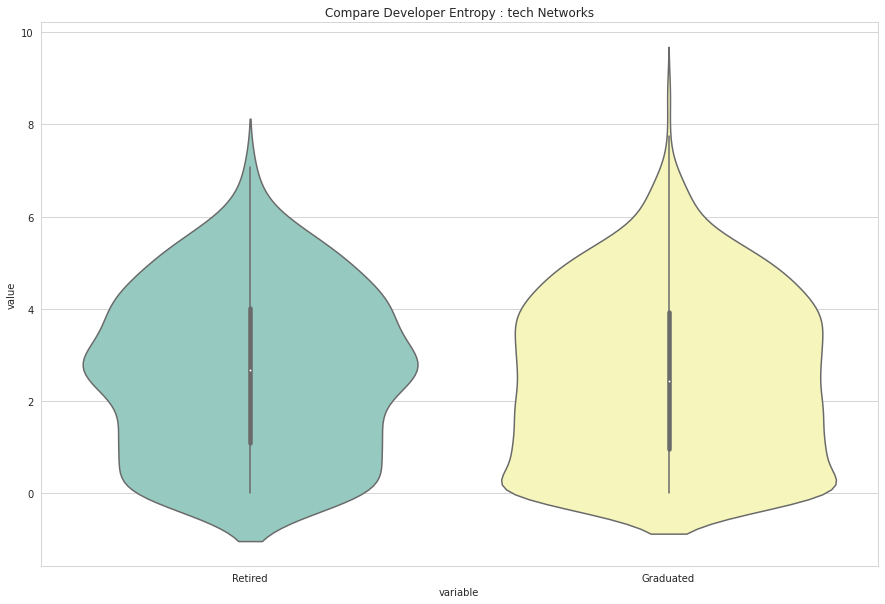

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="variable", y="value",
                    data=dd,
                    scale="width", palette="Set3")
plt.title("Compare Developer Entropy : tech Networks")

Text(0.5, 1.0, 'Compare Developer Entropy : tech Networks')

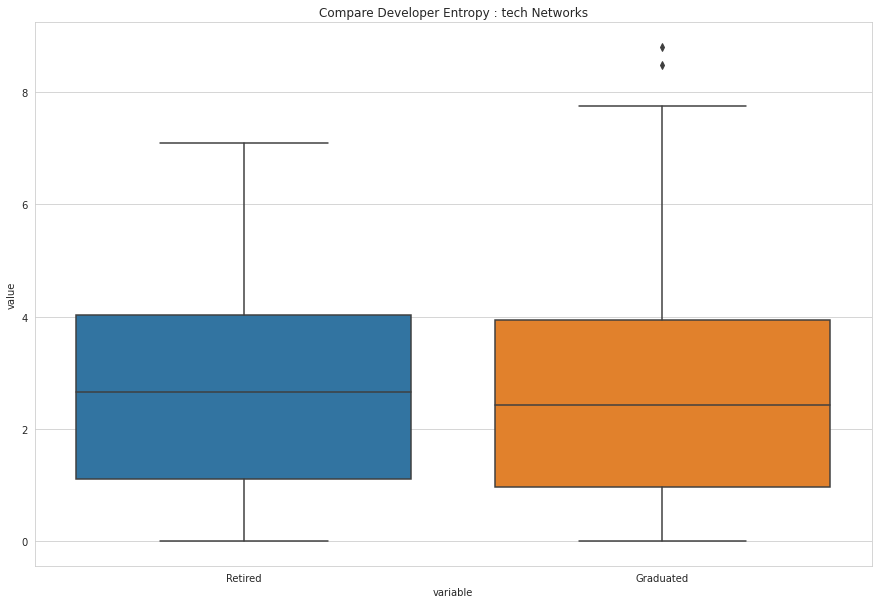

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.boxplot(x="variable", y="value",
                    data=dd)
plt.title("Compare Developer Entropy : tech Networks")

In [21]:
the_path = e_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_social_developer_entropy = pd.DataFrame()
all_social_developer_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict_andreverse(the_path, projid)
    #print(proj_dict)
    #proj_entropy = dict_entropy_calc(proj_dict)
    proj_nodes_entropy = {}
    #proj_series_entropy.append(proj_entropy)
    for node in proj_dict.keys():
        this_node_entropy = node_entropy_calc(proj_dict[node])
        proj_nodes_entropy[node] = this_node_entropy
    
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_social_developer_entropy[projname] = proj_nodes_entropy
    #print(projname)
    this_proj_nodes_e = list(proj_nodes_entropy.values())
    for seq_num in range(len(this_proj_nodes_e), 600):
        this_proj_nodes_e.append(-1.0)
    df_social_developer_entropy[projname] = pd.Series(this_proj_nodes_e)
df_social_developer_entropy = df_social_developer_entropy.fillna(-1.0) 
df_social_developer_entropy.to_csv("./social_developer_entropy"+str(time_resolution)+".csv", index=None, sep=',')
    

100%|██████████| 272/272 [00:02<00:00, 96.49it/s] 


In [22]:
df_social_developer_entropy

,Edgent,hdt,Mnemonic,Juneau,odf,Taverna,zeta,Streams,Oozie,Roller,...,Concerted,APISIX,Lens,Subversion,juddi,MyFaces,struts,MetaModel,pubscribe,Kabuki
0,2.497467,1.959694,2.315602,1.559102,1.822457,0.210283,2.666888,2.844399,3.584427,2.655481,...,0.867563,2.873072,0.636514,3.094210,1.472938,3.512032,3.734670,1.706584,1.445566,0.000000
1,2.616031,1.846169,2.585573,1.158595,3.061229,2.984459,2.989044,1.652030,2.936112,1.908134,...,1.187596,2.416710,2.883798,3.507693,1.088900,1.039721,2.400719,2.513264,1.372084,0.500402
2,2.017021,1.861280,2.210075,1.267497,0.000000,2.309028,2.818578,1.375645,2.927718,3.128009,...,1.324493,2.447008,2.016614,3.341998,1.664669,2.360027,2.908415,1.398018,1.659012,1.277034
3,2.625609,2.132251,1.946275,2.031027,2.086330,2.402392,2.648105,1.677038,3.666292,3.085654,...,0.693147,2.067758,2.447450,3.092493,0.693147,2.684186,3.028143,1.806609,0.000000,0.000000
4,1.830322,1.964203,1.532789,1.647900,1.709022,1.985101,2.163331,1.240981,1.012331,3.091365,...,1.273028,1.039721,2.315533,1.957116,1.418484,2.160964,4.134063,1.609952,1.242255,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
596,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
597,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
598,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [23]:
all_g = list()
for x in all_graduated_name:
    if x in all_social_developer_entropy.keys():
        all_g.append(x)
    elif x.lower() in all_social_developer_entropy.keys():
        all_g.append(x.lower())

all_r = list()
for x in all_retired_name:
    if x in all_social_developer_entropy.keys():
        all_r.append(x)
    elif x.lower() in all_social_developer_entropy.keys():
        all_r.append(x.lower())

g_data = []
for proj in all_g:
    g_data.extend(df_social_developer_entropy[proj].values.tolist())

r_data = []
for proj in all_r:
    r_data.extend(df_social_developer_entropy[proj].values.tolist())

df_graph = pd.DataFrame()
df_graph["Retired"] = pd.Series(r_data)
df_graph["Graduated"] = pd.Series(g_data)


dd = pd.melt(df_graph).dropna()
dd = dd.drop(dd[dd['value']==-1.0].index)

Text(0.5, 1.0, 'Compare Developer Entropy : Social Networks')

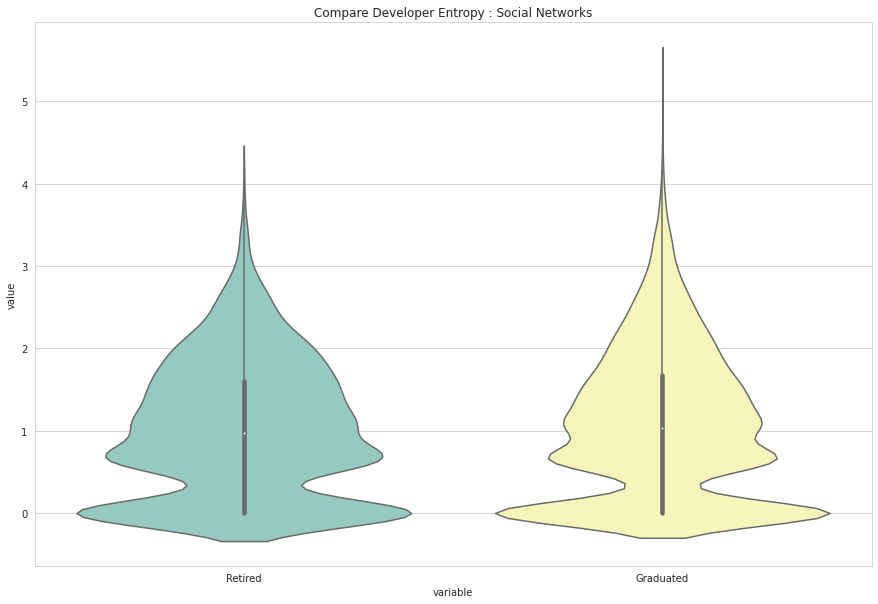

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="variable", y="value",
                    data=dd,
                    scale="width", palette="Set3")
plt.title("Compare Developer Entropy : Social Networks")

Text(0.5, 1.0, 'Compare Developer Entropy : Social Networks')

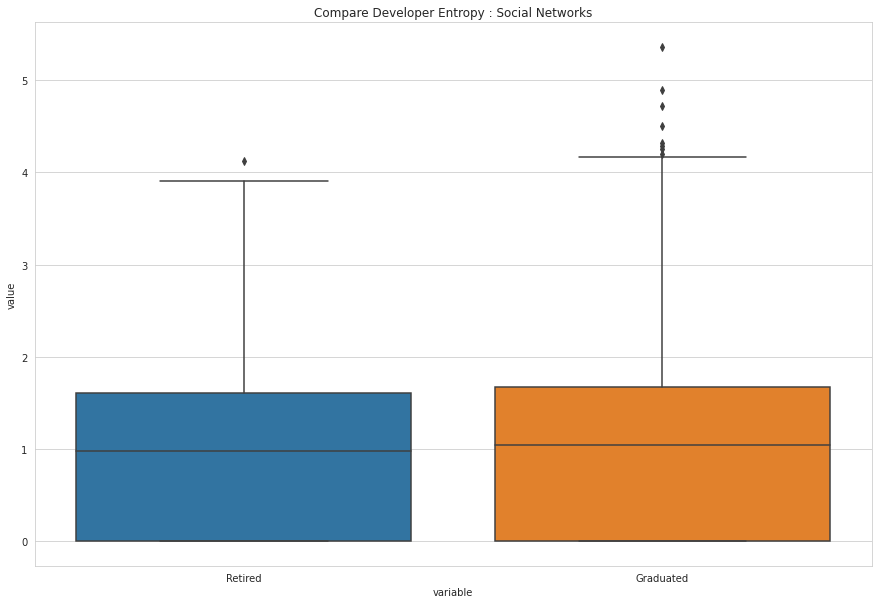

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.boxplot(x="variable", y="value",
                    data=dd)
plt.title("Compare Developer Entropy : Social Networks")